# 학습결과 Inference 코드 

In [1]:
# 주요 라이브러리 로드 

In [2]:
import os 
from mmdet.apis import init_detector, show_result_pyplot
from mmrotate.apis import inference_detector_by_patches
import mmrotate
import torch
print(mmrotate)
mmrotate.__version__=='0.3.4'

/mnt/hdd/eric/0.anaconda_root/lib/python3.8/site-packages/_distutils_hack/__init__.py:24: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/mnt/hdd/eric/0.anaconda_root/lib/python3.8/site-packages/_distutils_hack/__init__.py:36: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/mnt/hdd/eric/0.anaconda_root/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmc

<module 'mmrotate' from '/mnt/hdd/eric/.tmp_ipy/00.Reproduction_Test/mmrotate/__init__.py'>


True

# 추론 시 모델 선택 (중요)
- 학습시에 저장된 model weights 들 중 8 epoch weight 가 균일하게 가장 성능이 좋았으므로,   
00.Checkpoint 폴더에서 epoch_8.pth 체크포인트 모델을 골라서 inference를 실행해야 함 (중요)
재학습시에도 8 epoch 선택 동일 

In [3]:
# 실제 학습웨이트에서 8에폭 웨이트를 사용 
choose_epoch = 8

# 대회시에 학습되었던 웨이트들은 모두 00.Weights/trained_weights_competition_period 폴더 안에 위치하고 있음. 
checkpoint_file = f"/mnt/hdd/eric/.tmp_ipy/00.Weights/trained_weights_competition_period/finetune_roiTrans_epoch_{choose_epoch}.pth"

# config
config_file = '/mnt/hdd/eric/.tmp_ipy/00.Reproduction_Test/configs/kfiou/roi_trans_kfiou_ln_r50_fpn_1x_dota_ms_rr_le90.py'


In [5]:
from mmcv import Config

cfg = Config.fromfile(config_file)

In [6]:
#--------------------------------------
#----- classes
cfg.model.roi_head.bbox_head[0].num_classes=1 
cfg.model.roi_head.bbox_head[1].num_classes=1

classes = ('oiltank',)
cfg.data.train.classes=classes
cfg.data.val.classes=classes
cfg.data.test.classes=classes

# batch 
cfg.data.samples_per_gpu = 1

cfg.gpu_ids = [0]
cfg.device='cuda'
cfg.seed=22

# random seed
from mmdet.apis import set_random_seed
set_random_seed(cfg.seed,deterministic=True)

In [7]:
model = init_detector(cfg, checkpoint_file, device='cuda:0')

/mnt/hdd/eric/0.anaconda_root/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: /mnt/hdd/eric/.tmp_ipy/00.Weights/trained_weights_competition_period/finetune_roiTrans_epoch_8.pth


In [8]:
import cv2
img = cv2.imread('/mnt/hdd/eric/.tmp_ipy/0.data/oiltank_dataset/data/roas/test/images/OBJ05155_PS3_K3A_NIA0336.png')

In [9]:
from easydict import EasyDict

args = EasyDict()
args.img = img
args.patch_sizes = [1024,800,2048]
args.patch_steps = [824,672,1920]
args.img_ratios = [1.0,1.5,2.0]
args.merge_iou_thr = 0.1
args.device = 'cuda:0'
args.score_thr = 0.1
args.palette = 'dota'

/mnt/hdd/eric/0.anaconda_root/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


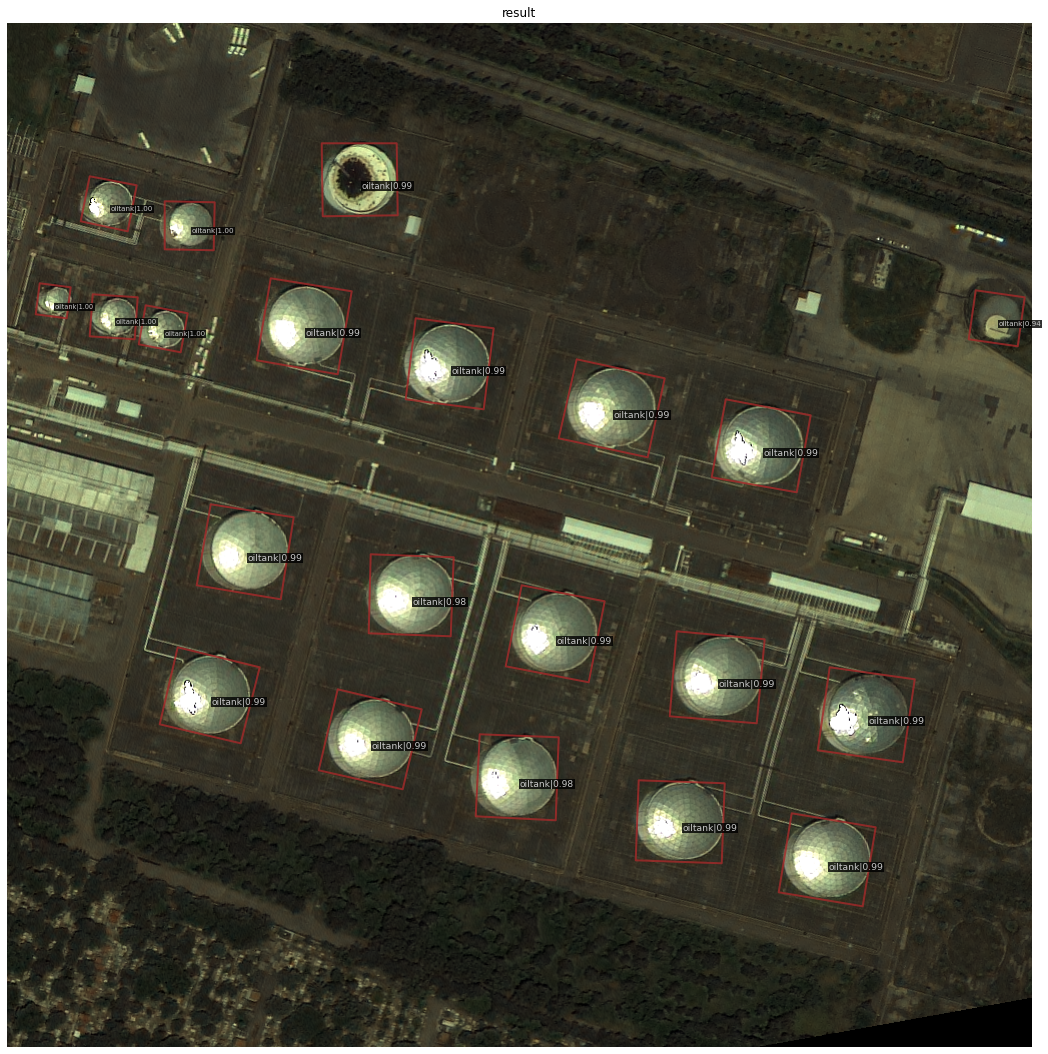

In [10]:
result = inference_detector_by_patches(model, args.img, args.patch_sizes,
                                        args.patch_steps, args.img_ratios,
                                        args.merge_iou_thr)
# show the results
show_result_pyplot(
    model,
    args.img,
    result,
    palette=args.palette,
    score_thr=args.score_thr)


In [ ]:
import os 

# competition valid images 
# competition dataset 의 위치 
valid_image_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/" + "oiltank_dataset/roas/test/images"

test_images = [os.path.join(valid_image_path,i) for i in os.listdir(valid_image_path) if ".png" in i ]

outputs= []
cnt=0
total_cnt = len(test_images)
for img_name in test_images:
    img = cv2.imread(f'{img_name}')
    result =  inference_detector_by_patches(model,img, args.patch_sizes,
                                        args.patch_steps, args.img_ratios,
                                        args.merge_iou_thr)
    outputs.append(result)
    cnt+=1
    print(cnt/total_cnt)

0.014705882352941176
0.029411764705882353
0.04411764705882353
0.058823529411764705


In [ ]:
outputs.__len__() # should be 68

68

In [ ]:
outputs[0][0][0]

array([ 3.0545e+02,  7.8250e+02,  3.2031e+01,  3.1086e+01, -1.1369e-01,  9.9538e-01], dtype=float32)

In [ ]:
import numpy as np
def center_to_corner(center_boxes):
    center_boxes = torch.Tensor(center_boxes)
    """
    input
    center_boxes : center coordinates boxes : [N, 4] (cx, cy, w, h)
    output
    corner_boxes : corner coordinates boxes : [N, 4] (x1, y1, x2, y2)
    """
    x1y1 = center_boxes[..., :2] - (center_boxes[..., 2:4])/2
    x2y2 = center_boxes[..., :2] + (center_boxes[..., 2:4])/2
    corner_boxes = torch.cat([x1y1, x2y2], dim=-1)
    corner_boxes = np.array(corner_boxes)
    return corner_boxes

In [ ]:
def conver4to8(box1 ): # this is corner coordinates ...
    #xmin,ymin,w,h = box[0],box[1], box[2],box[3],
    # 아,, faster RCNN은 corner output 이었는데,, 
    # ,,,, ROI Transformer 는 또,, center format 이네 ㅋ
    # 1 
    x1 = box1[0]
    y1 = box1[1]

    x2 = box1[2]
    y2 = box1[1]

    x3 = box1[2]
    y3 = box1[3]

    x4 = box1[0]
    y4 = box1[3]
    return [x1,y1,x2,y2,x3,y3,x4,y4]


Sub_ = {
    'File':[],'Confidence':[],'X1':[],'Y1':[],'X2':[],'Y2':[],'X3':[],'Y3':[],'X4':[],'Y4':[],
    }

import os 
f_names = [i[0:8] for i in os.listdir(valid_image_path)]

for i,img in enumerate(outputs):
    boxes = img[0]
    filename = f_names[i]
    for box in boxes:
        #xmin,ymin,w,h,confi = box[0],box[1],box[2],box[3],box[4]
        confi = box[5]
        if confi >= 0.1:
            corner_box = center_to_corner(box[0:4])
            coords8 = conver4to8(corner_box)
            confi = confi
            
            Sub_['File'].append(filename)
            Sub_['Confidence'].append(confi)
            Sub_['X1'].append(coords8[0]) # 나중에 int 
            Sub_['Y1'].append(coords8[1])
            Sub_['X2'].append(coords8[2])
            Sub_['Y2'].append(coords8[3])
            Sub_['X3'].append(coords8[4])
            Sub_['Y3'].append(coords8[5])
            Sub_['X4'].append(coords8[6])
            Sub_['Y4'].append(coords8[7])      

                

In [ ]:
import pandas as pd
Sub_ = pd.DataFrame(Sub_)

In [ ]:
Sub_

,File,Confidence,X1,Y1,X2,Y2,X3,Y3,X4,Y4
0,OBJ05465,0.995376,289.430573,766.953613,321.461578,766.953613,321.461578,798.040039,289.430573,798.040039
1,OBJ05465,0.995144,288.594727,730.338562,320.460266,730.338562,320.460266,761.636780,288.594727,761.636780
2,OBJ05465,0.993773,331.142853,767.027710,362.344208,767.027710,362.344208,797.324463,331.142853,797.324463
3,OBJ05465,0.992347,330.289246,728.110229,363.568542,728.110229,363.568542,761.379272,330.289246,761.379272
4,OBJ05465,0.279768,145.935455,474.892731,166.476074,474.892731,166.476074,491.916534,145.935455,491.916534
...,...,...,...,...,...,...,...,...,...,...
1362,OBJ03805,0.551959,710.404663,5.407140,734.325806,5.407140,734.325806,28.824722,710.404663,28.824722
1363,OBJ03805,0.504413,659.278137,338.188782,687.509460,338.188782,687.509460,363.747620,659.278137,363.747620
1364,OBJ03805,0.420392,633.358276,335.936798,643.852905,335.936798,643.852905,345.402618,633.358276,345.402618
1365,OBJ03805,0.223107,567.888611,256.503357,574.466736,256.503357,574.466736,262.098511,567.888611,262.098511


In [ ]:
# 최종 submission 파일 저장위치 

Sub_.to_csv("/mnt/hdd/eric/.tmp_ipy/00.Checkpoint/_재검증_final_submission_epoch_8.csv",index=False)